## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [5]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
# load data
# ----------
file_names_targets = pd.read_csv('/datasets/faces/labels.csv')
file_names_targets.head()
 
image_generator = ImageDataGenerator(rescale=1/255)
data_loader = image_generator.flow_from_dataframe(
    file_names_targets,
    '/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(150, 150),
    batch_size=16
)

Found 7591 validated image filenames.


## EDA

images: (32, 224, 224, 3)
ages: [51 12 40 63 50 51 47 40 35 35 34  5 27 17 28 32 28 35 23 24 58 28 27 43
 37 20 24 37 44  7 25 18]


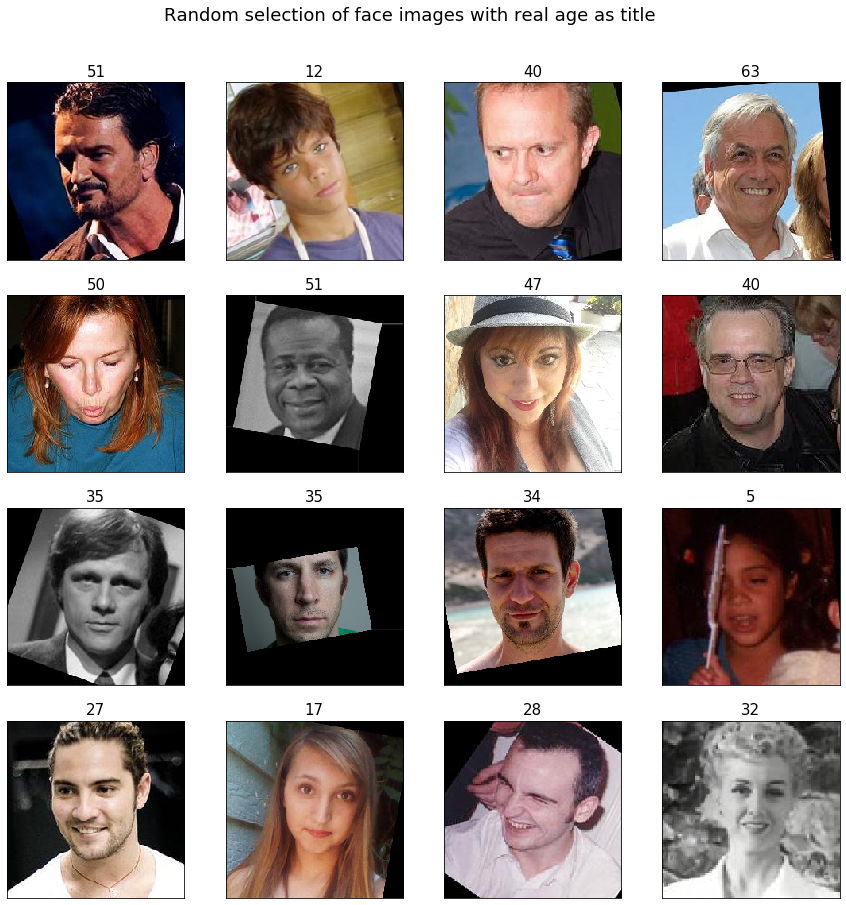

In [7]:
# load a random set of images
random_batch_images = next(train_gen_flow)
 
# unpack images and ages
images, ages = random_batch_images
 
print(
    f"images: {images.shape}\n"
    f"ages: {ages}"
)
 
# visualize random batch of images
fig, axes = plt.subplots(
    nrows = 4,
    ncols=4,
    figsize=(15, 15)
)

zipped = zip(axes.flatten(), images, ages)
for ax, image, age in zipped:
    ax.imshow(image)
    ax.set_title(age, size=15)
    ax.set
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
 
fig.suptitle(
    f"Random selection of face images with real age as title",
    size=18,
    y=0.95
);

0

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


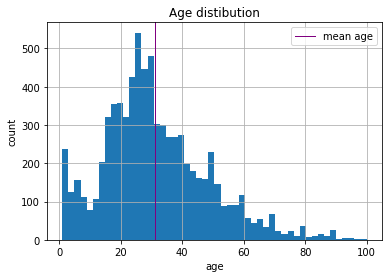

In [8]:
# plot age distribution
def plot_stat(
        data, stat_func=np.mean,
        **kwargs):
    stat = stat_func(data)
    keywords = {
        'c': 'purple',
        'lw': 1,
        'label': 'mean'
    }
    if kwargs:
        keywords.update(kwargs)
    plt.axvline(
        x=stat,
        **keywords
    )
 
ages = file_names_targets['real_age']
ages.hist(bins=50)
plot_stat(ages, **{'label': 'mean age', })
plt.legend()
plt.xlabel('age')
plt.ylabel('count')
plt.title("Age distibution");
 
# statistics
print((ages == 0).sum())
print()
print(ages.describe())


### Findings

- We have 7,591 image files in our dataset.

- The ages range between 1 and 100. the average age is 31 and the meadian is 29.

- Distribution: There is a peak between ages 16-31 and from 31 and up the numbers are decreasing.

- Since our task is to predict the age, its a regression task. We will train the model with ReLU (Rectified Linear Unit) activation function which range from 0 to infinity.

- We will use ResNet50 architecture, which can handle big amounts of data as we have in images.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path + "final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    ) 

    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path + "final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345,
    )

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

In [ ]:
2021-12-27 13:23:34.170437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-12-27 13:23:34.547095: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-12-27 13:23:47.415724: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-27 13:23:48.053712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-27 13:23:48.053782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-27 13:23:48.053813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-27 13:23:48.376028: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-27 13:23:48.471795: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-12-27 13:23:49.135100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-12-27 13:23:49.196706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-12-27 13:23:49.196828: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-27 13:23:49.201352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-12-27 13:23:49.201756: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-12-27 13:23:49.442461: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-12-27 13:23:49.445035: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4894500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-27 13:23:49.445068: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-27 13:23:49.820376: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x491a520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-12-27 13:23:49.820420: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-12-27 13:23:49.822997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-27 13:23:49.823049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-27 13:23:49.823059: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-27 13:23:49.823082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-27 13:23:49.823091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-12-27 13:23:49.823100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-12-27 13:23:49.823108: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-12-27 13:23:49.823115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-27 13:23:49.827384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-12-27 13:23:49.840911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-27 13:23:56.903920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-27 13:23:56.903968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-12-27 13:23:56.903976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-12-27 13:23:56.914733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-12-27 13:24:36.371549: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-27 13:24:40.248864: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 118s - loss: 211.6082 - mae: 10.7417 - val_loss: 623.6732 - val_mae: 19.9842
Epoch 2/10
178/178 - 36s - loss: 100.3623 - mae: 7.6479 - val_loss: 367.9933 - val_mae: 14.3150
Epoch 3/10
178/178 - 36s - loss: 67.3162 - mae: 6.2521 - val_loss: 628.5974 - val_mae: 19.7361
Epoch 4/10
178/178 - 36s - loss: 43.3305 - mae: 5.0364 - val_loss: 219.0807 - val_mae: 10.7122
Epoch 5/10
178/178 - 36s - loss: 29.2220 - mae: 4.1847 - val_loss: 145.7367 - val_mae: 9.3620
Epoch 6/10
178/178 - 36s - loss: 22.1972 - mae: 3.6536 - val_loss: 82.4462 - val_mae: 6.9366
Epoch 7/10
178/178 - 36s - loss: 15.1033 - mae: 3.0083 - val_loss: 80.9619 - val_mae: 6.7029
Epoch 8/10
178/178 - 36s - loss: 12.0789 - mae: 2.6815 - val_loss: 71.4947 - val_mae: 6.2948
Epoch 9/10
178/178 - 36s - loss: 11.0689 - mae: 2.5637 - val_loss: 72.5218 - val_mae: 6.3703
Epoch 10/10
178/178 - 36s - loss: 8.9100 - mae: 2.2863 - val_loss: 75.6404 - val_mae: 6.4733
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 75.6404 - mae: 6.4733
Test MAE: 6.4733

## Conclusions

We have got MAE score of 6.4733 for the test set. It means our average error in the task of age evaluation according to customer's photo is too high.
for example, we can mistakely determine 15 years old boy as 19, and allow him to buy alcohol, or determine 22 year old women as 17 and prohibit her buying alcohol.

For the task we were given, we need MAE less then 1 year.

The model however, can help and save time if we will take the error into account and let him decide by himself only in cases where the age that was evaluated is old enough. we will have to find the error distribution and in what age the probability of mistake is small enough.